In [10]:
#!/usr/bin/env python
from os.path import join
from glob import glob
import pandas as pd
import numpy as np
import scipy
import sys
from scipy import optimize
from sklearn.base import BaseEstimator
from pymbar import BAR as BAR_
import matplotlib.pyplot as plt
from optparse import OptionParser
import warnings
warnings.filterwarnings('ignore')

class optParser():
    def __init__(self,fakeArgs):

        parser = OptionParser()
        parser.add_option('-a', '--software', dest = 'software', help = 'Package\'s name the data files come from: gmx or amber. Default: gmx.', default = 'gmx')
        parser.add_option('-b', '--fraction', dest = 'fraction', help = 'The fraction of the energy file will be used to calculate the statistics. Default: 1.0',  default = 1.0, type = float)
        parser.add_option('-d', '--dir', dest = 'datafile_directory', help = 'Directory in which data files are stored. Default: Current directory.', default = '.')
        parser.add_option('-p', '--prefix', dest = 'prefix', help = 'Prefix for datafile sets, i.e.\'md\'.', default = '')
        parser.add_option('-q', '--suffix', dest = 'suffix', help = 'Suffix for datafile sets, i.e. \'xvg\' (default).', default = 'xvg')
        parser.add_option('-t', '--temperature', dest = 'temperature', help = "Temperature in K. Default: 298 K.", default = 298, type=float)
        parser.add_option('-r', '--restrain_windows', dest = 'restrain_windows', help = "Number of windows for adding restraints. Default: 0.", default = 0, type=int)
        parser.add_option('--draw', dest = 'draw_fit', help = 'Whether draw fitted figure. Default: False', default = False, action = 'store_true')
        parser.add_option('--ga_bins', dest = 'ga_bins', help = "Number of bins for gaussian algorithms fit. Default: 250.", default = 250, type=int)
        parser.add_option('--rd_bins', dest = 'rd_bins', help = "Number of bins for restrain distribution fit. Default: 500.", default = 500, type=int)
        parser.add_option('--out_png', dest = 'out_png', help = "Output png file name if --draw option is specified.", default = '')
        parser.add_option('--out_ene', dest = 'out_ene', help = "Output ene file name", default = '')
        if fakeArgs:
            self.option, self.args = parser.parse_args(fakeArgs)
        else:
            self.option, self.args = parser.parse_args()



class MDParser():
    def __init__(self, parser='gmx'):
        if parser=='gmx':
            from alchemlyb.parsing.gmx import extract_u_nk
        if parser=='amber':
            from alchemlyb.parsing.amber import extract_u_nk
        self.extract_u_nk = extract_u_nk


class FEP():
    def __init__(self, d_u):
        self.u_l=np.array(d_u)
        exponential=np.exp(-self.u_l)
        expave=exponential.mean()
        self.ene=-np.log(expave)
        

class GA_FIT():
    def __init__(self, d_u):
        self.u_l=np.array(d_u)
        self.u_mean = np.mean(self.u_l)

        where_are_inf = np.isinf(self.u_l)
        if self.u_mean > 0:
            self.u_l[where_are_inf] = 999.0
        else:
            self.u_l[where_are_inf] = -999.0

        self.u_std = np.std(self.u_l)
        self.decompRD = False      
        


    
    def residues_common(self,p,f,y,x):
        return np.sum((y-f(p,x))**2)
        
    def func_ga(self,p,x):
        a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4, a5, b5, c5 = p
        return abs(a1) * 1/(np.sqrt(np.pi)*abs(c1)) * np.exp(-(x-b1)**2/(2*c1**2))\
                    + abs(a2) * 1/(np.sqrt(np.pi)*abs(c2)) * np.exp(-(x-b2)**2/(2*c2**2))\
                    + abs(a3) * 1/(np.sqrt(np.pi)*abs(c3)) * np.exp(-(x-b3)**2/(2*c3**2))\
                    + abs(a4) * 1/(np.sqrt(np.pi)*abs(c4)) * np.exp(-(x-b4)**2/(2*c4**2))\
                    + abs(a5) * 1/(np.sqrt(np.pi)*abs(c5)) * np.exp(-(x-b5)**2/(2*c5**2))
    

    #def cost_c(self,x,std):
    #    return 1/(abs(x)+2-std)**2 - 1/(abs(x)+2-std)
    def cost_c(self,x,std):
        return 1/(2*x/std)**2 - 1/(2*x/std)

    def cost_c4(self,x,std):
        return 1/(1.414*x/std)**4 - 1/(1.414*x/std)**2
    
    def residues_ga(self,p,f,y,x):
        a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4, a5, b5, c5 = p
        cost_c=self.cost_c
        u_std=self.u_std
        #return np.sum((y-f(p,x))**2)
        #return np.sum((y-f(p,x))**2)+0.01*((b1-self.u_mean)**2+(b2-self.u_mean)**2+(b3-self.u_mean)**2+(b4-self.u_mean)**2+(b5-self.u_mean)**2)
        #return np.sum((y-f(p,x))**2)+\
        #     0.01*(cost_c(c1,u_std)+cost_c(c2,u_std)+cost_c(c3,u_std)+cost_c(c4,u_std)+cost_c(c5,u_std))+\
        #     0.0001*((b1-self.u_mean)**2+(b2-self.u_mean)**2+(b3-self.u_mean)**2+(b4-self.u_mean)**2+(b5-self.u_mean)**2)
        #return np.sum((y-f(p,x))**2)-0.1*(c1**2+c2**2+c3**2+c4**2+c5**2)
        #return np.sum((y-f(p,x))**2)-0.1*(c1**2+c2**2+c3**2+c4**2+c5**2)+((b1-self.u_mean)**2+(b2-self.u_mean)**2+(b3-self.u_mean)**2+(b4-self.u_mean)**2+(b5-self.u_mean)**2)
        #return np.sum((y-f(p,x))**2)+\
        #     0.01*(cost_c(c1,u_std)+cost_c(c2,u_std)+cost_c(c3,u_std)+cost_c(c4,u_std)+cost_c(c5,u_std))
        return np.sum((y-f(p,x))**2)+\
             0.00*(cost_c(c1,u_std)+cost_c(c2,u_std)+cost_c(c3,u_std)+cost_c(c4,u_std)+cost_c(c5,u_std))+\
             0.00*((b1/self.u_mean-1)**2+(b2/self.u_mean-1)**2+(b3/self.u_mean-1)**2+(b4/self.u_mean-1)**2+(b5/self.u_mean-1)**2)

        
    def ga4rd(self,p,x):
        a1, b1, c1 = p
        return abs(a1) * 1/(np.sqrt(np.pi)*abs(c1)) * np.exp(-(x-b1)**2/(2*c1**2))

    def gm4rd(self,p,x):
        a1, b1, c1 = p
        #return  np.exp(b1-a1) * x**2 * np.exp(-b1 * x - c1 * x**10)
        return abs(a1) * (b1**2) * abs(x) * np.exp(-b1 * abs(x) - (c1 * x)**4)  #b1**2 term is for normalization
    
    def func_rd(self,p,x): # residue distribution function
        a1, b1, c1, d1, a2, b2, c2= p
        p0 = [ a1, b1, c1 ]
        p1 = [ a2, b2, c2 ]
#         return self.gm4rd(p0,x) #no gaussian
        return self.gm4rd(p0,x)+ 1/(1+(abs(d1)**4/abs(x)**4)) * (self.ga4rd(p1,x))
        #return abs(a1) * x**2 * np.exp(-(x)*b1-c1*x**2) + 1/(1+np.exp(-d1*x + e1)) * self.func_ga(p0,x)
        #return abs(1000*a1) * x**2 * np.exp(-(abs(x))*b1-c1*x**4) + 1/(abs(d1)/np.sqrt(abs(x))+1) * (self.ga4rd(p0,x))
        #return abs(1000*a1) * x**2 * np.exp(-(abs(x))*b1) + 1/(1+(abs(d1)/abs(x))**4) * (self.ga4rd(p0,x))
                                            
                        
    def residues_rd(self,p,f,y,x):
                                            
        a1, b1, c1, d1, a2, b2, c2= p
        cost_c=self.cost_c
        cost_c4=self.cost_c4
        u_std=self.u_std
        #return np.sum((y-f(p,x))**2)
        #return np.sum((y-f(p,x))**2)+0.01*((b1-self.u_mean)**2+(b2-self.u_mean)**2+(b3-self.u_mean)**2+(b4-self.u_mean)**2+(b5-self.u_mean)**2)
        #return np.sum((y-f(p,x))**2)+\
        #     1*(cost_c(c2,u_std)+cost_c(c3,u_std)+cost_c(c4,u_std)+cost_c(c5,u_std)+cost_c(c6,u_std))+\
        #     0.0*((b2-self.u_mean)**2+(b3-self.u_mean)**2+(b4-self.u_mean)**2+(b5-self.u_mean)**2+(b6-self.u_mean)**2)
       # return np.sum((y-f(p,x))**2)+\
       #      0.0*(cost_c(d1,self.u_mean))+\
       #      0.01*(cost_c(c2,u_std))+\
       #      1*(((a2-2)/2)**10)+\
       #      1*(cost_c(b2,self.u_mean))
           #  0.1*((b2-2*self.u_mean)**2)
        return np.sum((y-f(p,x))**2)+\
             0.00*((d1/(3*self.u_mean))**10)+\
             0.00*(cost_c4(d1,0.25*self.u_mean))+\
             0.01*(cost_c(c2,u_std))+\
             0.00**(((a2-2.5)/2)**10)+\
             0.00*(cost_c(b2,self.u_mean))
        #return np.sum((y-f(p,x))**2)+\
        #     1*(((d1-2*self.u_mean)/(self.u_mean))**10)+\
        #     0.01*(cost_c(c2,u_std))+\
        #     1*(((a2-2.5)/2)**10)+\
        #     0.00*(cost_c(b2,self.u_mean))
    

    def func_fit(self,func,p0,residues=residues_common,bins=250,add00=False):
        #get distribution histogram
        self.pu_arr,xu_arr_add1 = np.histogram(self.u_l,bins=bins,density=True)
        xu = []
        for i in range(len(xu_arr_add1)-1):
            xu.append((xu_arr_add1[i]+xu_arr_add1[i+1])/2)

        self.xu_arr = np.array(xu)
        
        fit_xu_arr=self.xu_arr
        fit_pu_arr=self.pu_arr
        
        if add00:
            fit_xu_arr = np.append(fit_xu_arr,0.0)
            fit_pu_arr = np.append(fit_pu_arr,0.0)
            if self.u_mean > 0:            
                maxval = fit_xu_arr.max()
                for i in range(5):
                    fit_xu_arr = np.append(fit_xu_arr,maxval+0.5*(i+1))
                    fit_pu_arr = np.append(fit_pu_arr,0.0)
            else:
                minval = fit_xu_arr.min()
                for i in range(5):
                    fit_xu_arr = np.append(fit_xu_arr,minval-0.5*(i+1))
                    fit_pu_arr = np.append(fit_pu_arr,0.0)
        
        plsq = optimize.fmin(residues, p0, args=(func, fit_pu_arr, fit_xu_arr),maxiter=100000)
        return plsq
        #print (plsq)

        #plsq_l=list(plsq[0])


    def ga_fit(self,bins=250,fit=True): #gaussian algorithms fit

        a1=a2=a3=a4=a5=a6=0.15
        b1=b2=b3=b4=b5=b6=self.u_mean
        c1=c2=c3=c4=c5=c6=self.u_std

        p0=[a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4, a5, b5, c5]
        if fit:
            plsq=self.func_fit(self.func_ga,p0,self.residues_ga,bins=bins)
        
            #fig        
            self.x = np.linspace(self.u_mean-6*self.u_std,self.u_mean+6*self.u_std,1000)
            self.fitted_y = self.func_ga(plsq,self.x)
            
            print (plsq)
            print ("Mean value: %10.5f STD: %10.5f" % (self.u_mean,self.u_std))
    
            self.fitted_u=[]
            for i in range(len(self.x)):
                    self.fitted_u += [self.x[i] for j in range(int(round(self.fitted_y[i]*10000.0)))]
            self.fitted_u=np.array(self.fitted_u)
        else:
            self.pu_arr,xu_arr_add1 = np.histogram(self.u_l,bins=bins,density=True)
            xu = []
            for i in range(len(xu_arr_add1)-1):
                xu.append((xu_arr_add1[i]+xu_arr_add1[i+1])/2)
     
            self.xu_arr = np.array(xu)
     
            self.x=self.xu_arr
            self.fitted_y=self.pu_arr
            self.fitted_u=self.u_l


    def rd_fit(self,bins=500): #restrain distribution fit

        a2=a3=a4=a5=a6=1
        b2=b3=b4=b5=b6=2*self.u_mean
        c2=c3=c4=c5=c6=3*self.u_std
        b1=1/abs(self.u_mean)
        a1=1
        c1=3
        d1=3*abs(self.u_mean)
        
        p0=[a1, b1, c1, d1, a2, b2, c2]
        plsq=self.func_fit(self.func_rd,p0,self.residues_rd,bins=bins,add00=True)
        #print (p0)
        #print (plsq)
        #fig
        if self.u_mean > 0:
            self.x = np.linspace(0, 1.0*self.u_l.max(),10000)
        else:
            self.x = np.linspace(1.0*self.u_l.min(),0, 10000)
        self.fitted_y = self.func_rd(plsq,self.x)
        
        # for figure decomp
        self.decompRD = True
        a1, b1, c1, d1, a2, b2, c2= plsq
        plsq_ga = [ a2, b2, c2 ]
        plsq_gm = [ a1, b1, c1 ]
        
        
        #return self.gm4rd(p0,x)+ 1/(1+(abs(d1)**4/abs(x)**4)) * (self.ga4rd(p1,x))

        self.fitted_harmonic_distrib_y = self.gm4rd(plsq_gm,self.x)
        #self.fitted_harmonic_distrib_y = abs(1000*a1) * self.x**2 * np.exp(-(abs(self.x))*b1)
                                        
        self.fitted_gauss_distrib_y = 1/(1+(abs(d1)**4/abs(self.x)**4)) * (self.ga4rd(plsq_ga,self.x))

        print (plsq)
        print (self.u_mean,self.u_std)
        
        
        self.fitted_u=[]
        for i in range(len(self.x)):
            self.fitted_u += [self.x[i] for j in range(int(round(self.fitted_y[i]*1000.0)))]
        self.fitted_u=np.array(self.fitted_u)

        
    def show_fit(self,pngfile):

        plt.clf()
        
        plt.title("Probability distribution") 
        plt.xlabel("delta_U") 
        plt.ylabel("Probability") 

       
        plt.plot(self.xu_arr,self.pu_arr,"oy")
        
        
        if self.decompRD:
            plt.plot(self.x,self.fitted_harmonic_distrib_y,color='green')
            plt.plot(self.x,self.fitted_gauss_distrib_y,color='blue')
            plt.plot(self.x,self.fitted_y,color='red') 
        
        if not pngfile:
            plt.show()
        else:
            plt.savefig(pngfile)

    def show_original_data(self):
        
        plt.title("Original probability distribution") 
        plt.xlabel("delta_U") 
        plt.ylabel("Probability") 

       
        plt.plot(self.xu_arr,self.pu_arr,"oy")
        
        plt.show()

class GABAR(BaseEstimator):

    def __init__(self,restrain_windows=0, maximum_iterations=10000, relative_tolerance=1.0e-7, method='false-position', verbose=False):

        self.maximum_iterations = maximum_iterations
        self.relative_tolerance = relative_tolerance
        self.method = method
        self.verbose = verbose
        self.restrain_windows = restrain_windows

        # handle for pymbar.BAR object
        self._bar = None

    def fit(self, u_nk, fraction=9999, draw_fit=False, ga_bins=250, rd_bins=500, out_png='', fit=False):

        # sort by state so that rows from same state are in contiguous blocks
        u_nk = u_nk.sort_index(level=u_nk.index.names[1:])

        # get a list of the lambda states
        self.states_ = u_nk.columns.values.tolist()

        # group u_nk by lambda states
        groups = u_nk.groupby(level=u_nk.index.names[1:])
        N_k = [(len(groups.get_group(i)) if i in groups.groups else 0) for i in u_nk.columns]

        # Now get free energy differences and their uncertainties for each step
        deltas = np.array([])
        d_deltas = np.array([])
        deltas_fit = np.array([])
        d_deltas_fit = np.array([])
        fepf_deltas = np.array([])
        fepr_deltas = np.array([])
        fepfitf_deltas = np.array([])
        fepfitr_deltas = np.array([])
        #self.delta_fepF_ = np.array([])
        #self.delta_fepB_ = np.array([])

        state_cut_head=state_cut_tail=False
        for k in range(len(N_k) - 1):
            # get us from lambda step k
            try:
                uk = groups.get_group(self.states_[k])
            except:
                state_cut_head=True
                continue   
            # get w_F
            w_f = uk.iloc[:, k+1] - uk.iloc[:, k]
            w_f = w_f.loc[w_f.index[-1][0]-1000*fraction:] #apply fraction
         
                
            try:
                # get us from lambda step k+1
                uk1 = groups.get_group(self.states_[k+1])
            except:
                state_cut_tail=True
                continue 
            # get w_R    
            w_r = uk1.iloc[:, k] - uk1.iloc[:, k+1]
            w_r = w_r.loc[w_r.index[-1][0]-1000*fraction:] #apply fraction

            f_fit=fit
            if w_f.std() < 0.01:
                f_fit=False
            r_fit=fit
            if w_r.std() < 0.01:
                r_fit=False
                
            wf_fit=GA_FIT(w_f)
#            wf_fit.show_original_data()
            wr_fit=GA_FIT(w_r)
#            wr_fit.show_original_data()
            if k < self.restrain_windows:
                wf_fit.rd_fit(bins=rd_bins)
                wr_fit.rd_fit(bins=rd_bins)
            else:
                wf_fit.ga_fit(bins=ga_bins,fit=f_fit)
                wr_fit.ga_fit(bins=ga_bins,fit=r_fit)
                
            if draw_fit:
                if out_png:
                    png_name_f=out_png+'_'+str(k)+'_f.png'
                    png_name_b=out_png+'_'+str(k)+'_r.png'
                else:
                    png_name_f=png_name_b=''
                wf_fit.show_fit(png_name_f)
                wr_fit.show_fit(png_name_b)

                        
            if k == 0:
                self.test_uk=uk
                self.test_uk1=uk1
                self.test_wf=w_f
                self.test_wr=w_r

            # now determine df and ddf using pymbar.BAR
            df_fit, ddf_fit = BAR_(wf_fit.fitted_u, wr_fit.fitted_u,
                             method=self.method,
                             maximum_iterations=self.maximum_iterations,
                             relative_tolerance=self.relative_tolerance,
                             verbose=self.verbose)
            #df_fit, ddf_fit = (0,0)
            deltas_fit = np.append(deltas_fit, df_fit)
            d_deltas_fit = np.append(d_deltas_fit, ddf_fit)
            
            df, ddf = BAR_(w_f, w_r,
                             method=self.method,
                             maximum_iterations=self.maximum_iterations,
                             relative_tolerance=self.relative_tolerance,
                             verbose=self.verbose)
           # df, ddf = (0,0)
            deltas = np.append(deltas, df)
            d_deltas = np.append(d_deltas, ddf)

           
            df_fep_f = FEP(w_f).ene
            df_fep_r = FEP(w_r).ene
            fepf_deltas=np.append(fepf_deltas, df_fep_f)
            fepr_deltas=np.append(fepr_deltas, df_fep_r)
                        
            
            df_fepfit_f = FEP(wf_fit.fitted_u).ene
            df_fepfit_r = FEP(wr_fit.fitted_u).ene            
            fepfitf_deltas=np.append(fepfitf_deltas, df_fepfit_f)
            fepfitr_deltas=np.append(fepfitr_deltas, df_fepfit_r)
            


        # build matrix of deltas between each state
        adelta = np.zeros((len(deltas) + 1, len(deltas) + 1))
        ad_delta = np.zeros_like(adelta)            

        adelta_fit = np.zeros((len(deltas_fit) + 1, len(deltas_fit) + 1))
        ad_delta_fit = np.zeros_like(adelta_fit)

        for j in range(len(deltas)):
            out = []
            dout = []
            out_fit = []
            dout_fit = []
            for i in range(len(deltas) - j):
                out.append(deltas[i:i + j + 1].sum())
                out_fit.append(deltas_fit[i:i + j + 1].sum())
                # See https://github.com/alchemistry/alchemlyb/pull/60#issuecomment-430720742
                # Error estimate generated by BAR ARE correlated

                # Use the BAR uncertainties between two neighbour states
                if j == 0:
                    dout.append(d_deltas[i:i + j + 1].sum())
                    dout_fit.append(d_deltas_fit[i:i + j + 1].sum())
                # Other uncertainties are unknown at this point
                else:
                    dout.append(np.nan)
                    dout_fit.append(np.nan)

            adelta += np.diagflat(np.array(out), k=j + 1)
            ad_delta += np.diagflat(np.array(dout), k=j + 1)
            adelta_fit += np.diagflat(np.array(out_fit), k=j + 1)
            ad_delta_fit += np.diagflat(np.array(dout_fit), k=j + 1)
            
        if state_cut_head : self.states_ = self.states_[1:] 
        if state_cut_tail : self.states_ = self.states_[:-1] 
        # yield standard delta_f_ free energies between each state
        
        self.adelta = adelta
        #self.out = out
        self.adelta_fit = adelta_fit
        #self.out_fit = out_fit
        
        self.delta_f_ = pd.DataFrame(adelta - adelta.T,
                                     columns=self.states_,
                                     index=self.states_)
        self.delta_fit_f_ = pd.DataFrame(adelta_fit - adelta_fit.T,
                                     columns=self.states_,
                                     index=self.states_)        

        # yield standard deviation d_delta_f_ between each state
        self.d_delta_f_ = pd.DataFrame(np.sqrt(ad_delta + ad_delta.T),
                                       columns=self.states_,
                                       index=self.states_)
        
        self.d_delta_fit_f_ = pd.DataFrame(np.sqrt(ad_delta_fit + ad_delta_fit.T),
                                       columns=self.states_,
                                       index=self.states_)
        
        
        #data
        self.delta_fepF_ = fepf_deltas
        self.delta_fepR_ = fepr_deltas
        self.delta_fepfitF_ = fepfitf_deltas
        self.delta_fepfitR_ = fepfitr_deltas
        self.delta_BAR_ = deltas
        self.delta_fitBAR_ = deltas_fit
        def getsum(data):
            outsum=[]
            for i in range(len(data)):
                outsum.append(data[:i+1].sum())
            return np.array(outsum)
        self.delta_fepF_sum_    = getsum(self.delta_fepF_)
        self.delta_fepR_sum_    = getsum(self.delta_fepR_)
        self.delta_fepfitF_sum_ = getsum(self.delta_fepfitF_)
        self.delta_fepfitR_sum_ = getsum(self.delta_fepfitR_)
        self.delta_BAR_sum_     = getsum(self.delta_BAR_)
        self.delta_fitBAR_sum_  = getsum(self.delta_fitBAR_)
        
        #data_delta

        self.d_delta_BAR_ = d_deltas
        self.d_delta_fitBAR_ = d_deltas_fit
        self.d_delta_BAR_sum_     = getsum(self.d_delta_BAR_)
        self.d_delta_fitBAR_sum_  = getsum(self.d_delta_fitBAR_)        
        
        columns=['BAR','d_BAR','BARsum','d_BARsum']
        zeros = np.zeros(len(columns))
        alldata=np.hstack((self.delta_fitBAR_.reshape(-1,1),
                           self.d_delta_fitBAR_.reshape(-1,1),
                           self.delta_fitBAR_sum_.reshape(-1,1),
                           self.d_delta_fitBAR_sum_.reshape(-1,1)
                          ))
        alldata=np.vstack((zeros,alldata))
        self.datas = pd.DataFrame(alldata, columns=columns, index=self.states_)
        

#         d_columns=['d_BAR','d_fitBAR','d_BARsum','d_fitBARsum']
#         d_zeros = np.zeros(len(d_columns))
#         d_alldata=np.hstack((
#                            self.d_delta_BAR_.reshape(-1,1),self.d_delta_fitBAR_.reshape(-1,1),
#                            self.d_delta_BAR_sum_.reshape(-1,1),self.d_delta_fitBAR_sum_.reshape(-1,1)
#                           ))
#         d_alldata=np.vstack((d_zeros,d_alldata))
#         self.d_datas = pd.DataFrame(d_alldata, columns=d_columns, index=self.states_)
        
        return self
    
    def print_result(self,out_ene):
        if out_ene:
            f_out_ene=open(out_ene,"w")
            print ("GABAR results: unit in kcal/mol",file=f_out_ene)
            print (self.datas*0.597,file=f_out_ene)
#             print (self.d_datas*0.597,file=f_out_ene)
        else:
            print ("GABAR results: unit in kcal/mol")
            print (self.datas*0.597)
#             print (self.d_datas*0.597)


In [11]:
    fakeArgs="-a gmx -b 3  -p md -q xvg -r 1 --draw" #only keep this for test purpose
    opts=optParser(fakeArgs.strip().split()) #only keep this for test purpose
    
    files=sorted(glob(join(opts.option.datafile_directory,opts.option.prefix+'*.'+opts.option.suffix)))
    u_nk_list=[MDParser(opts.option.software).extract_u_nk(xvg, T=opts.option.temperature) for xvg in files]
    u_nk = pd.concat(u_nk_list,sort=True)

Optimization terminated successfully.
         Current function value: 0.007310
         Iterations: 1091
         Function evaluations: 1632
[ 0.764329    1.52145595 -0.13244182  2.48032539  1.62719175 -4.24829753
  5.27847325]
2.4062160405478177 2.8590837315221456
Optimization terminated successfully.
         Current function value: 0.175222
         Iterations: 1016
         Function evaluations: 1527
[ 0.98346234  3.14112059 -0.85965342  1.24014764  2.39139562  0.39198081
  0.99334694]
-0.7060241196300507 0.5687794631426252


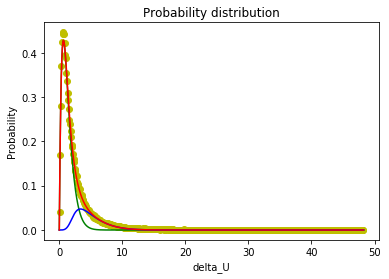

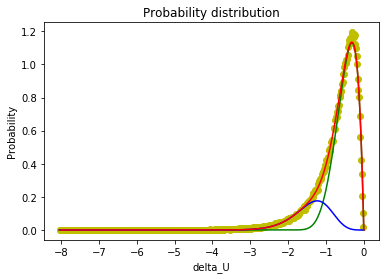

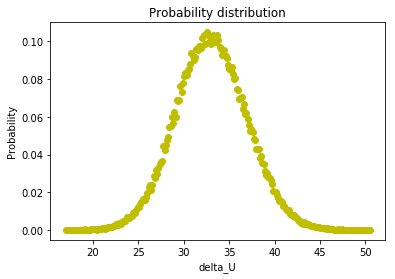

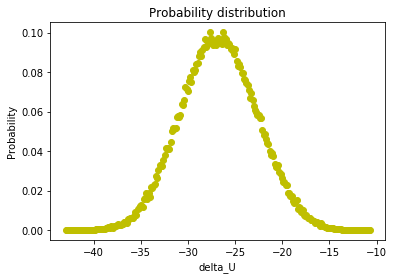

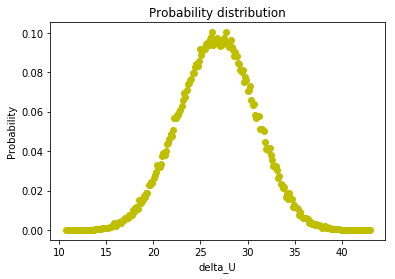

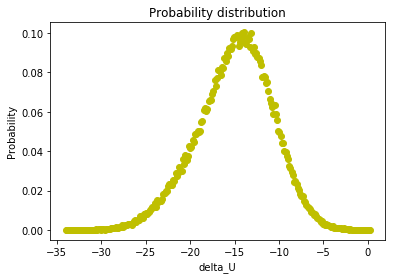

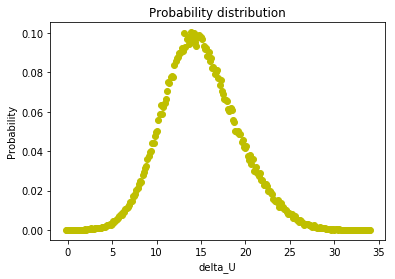

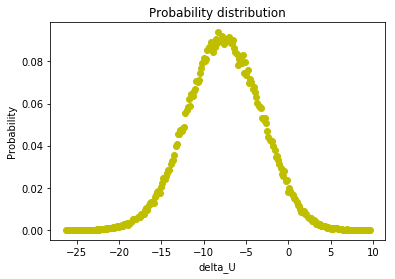

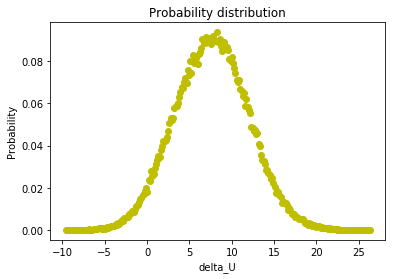

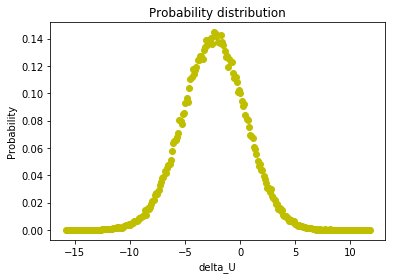

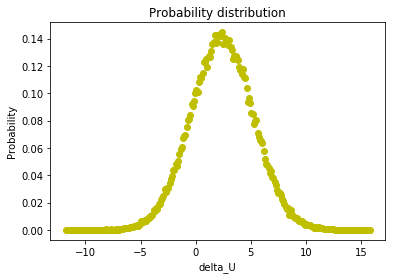

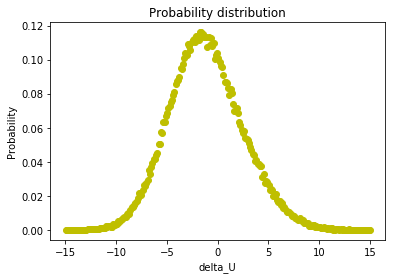

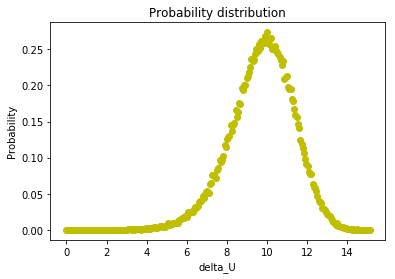

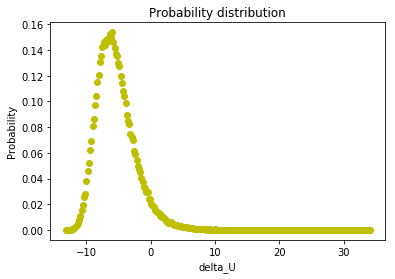

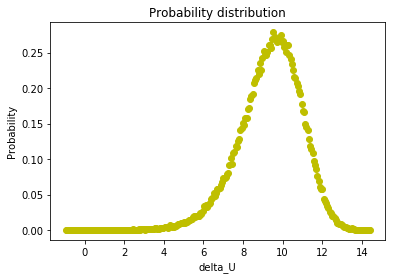

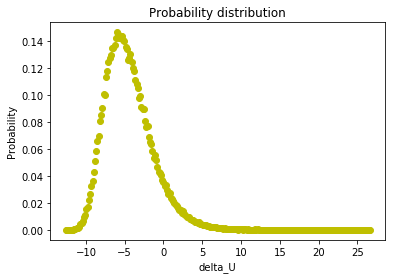

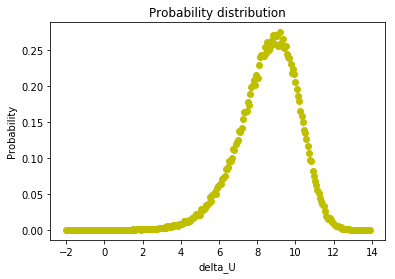

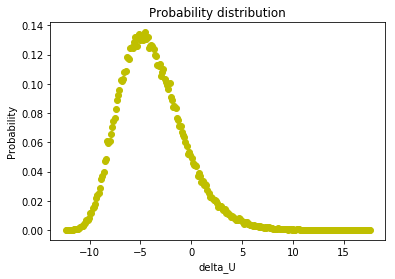

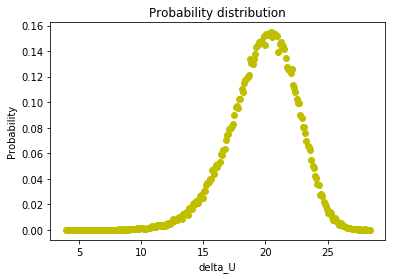

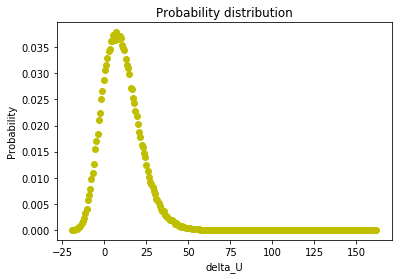

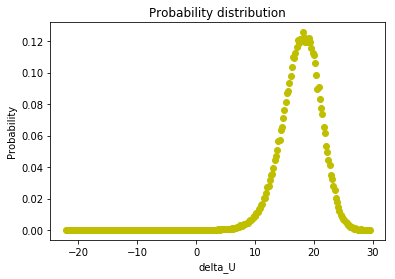

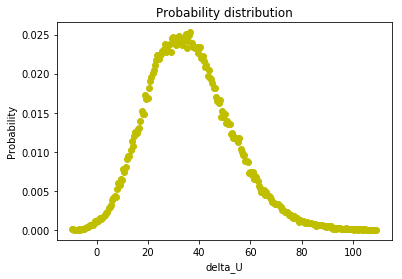

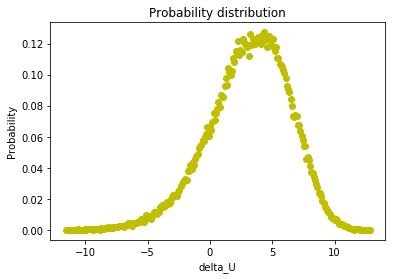

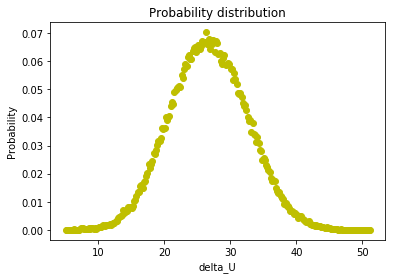

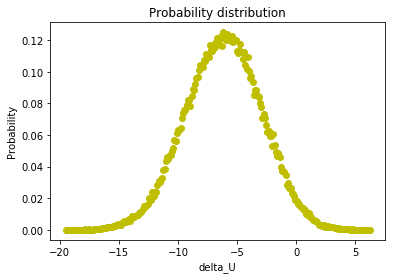

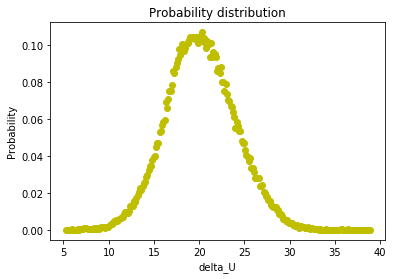

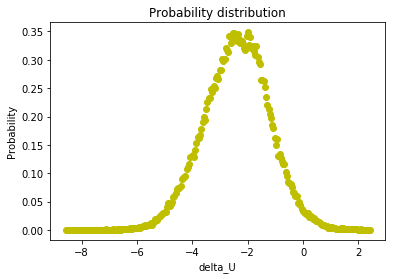

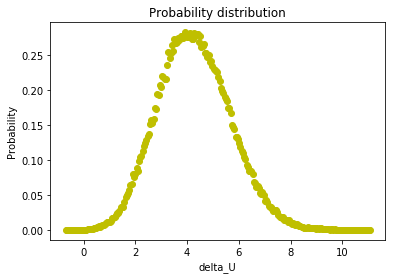

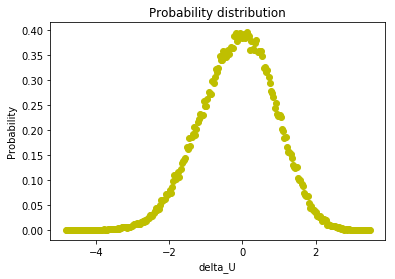

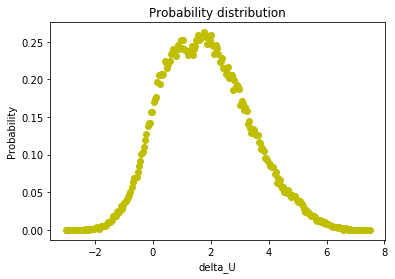

In [12]:
res_bar=GABAR(restrain_windows=opts.option.restrain_windows).fit(u_nk,fraction=opts.option.fraction,draw_fit=opts.option.draw_fit,ga_bins=opts.option.ga_bins,rd_bins=opts.option.rd_bins,out_png=opts.option.out_png)

In [13]:
res_bar.print_result(opts.option.out_ene)

GABAR results: unit in kcal/mol
                                  BAR     d_BAR     BARsum  d_BARsum
(0.0, 0.0, 0.0, 0.0, 0.0)    0.000000  0.000000   0.000000  0.000000
(0.0, 0.0, 0.0, 1.0, 0.0)    0.631801  0.000647   0.631801  0.000647
(0.0, 0.2, 0.0, 1.0, 0.0)   17.859854  0.003035  18.491654  0.003682
(0.0, 0.4, 0.0, 1.0, 0.0)   12.563817  0.005018  31.055471  0.008700
(0.0, 0.6, 0.0, 1.0, 0.0)    6.765077  0.003259  37.820548  0.011959
(0.0, 0.8, 0.0, 1.0, 0.0)    2.709249  0.002789  40.529797  0.014748
(0.0, 1.0, 0.0, 1.0, 0.0)    1.120556  0.001830  41.650353  0.016578
(0.0, 1.0, 0.1, 1.0, 0.0)    4.787052  0.002381  46.437405  0.018958
(0.0, 1.0, 0.2, 1.0, 0.0)    4.439560  0.002573  50.876965  0.021531
(0.0, 1.0, 0.3, 1.0, 0.0)    4.023356  0.002560  54.900322  0.024091
(0.0, 1.0, 0.5, 1.0, 0.0)    6.764244  0.015673  61.664566  0.039763
(0.0, 1.0, 0.7, 1.0, 0.0)    2.208258  0.051318  63.872824  0.091081
(0.0, 1.0, 0.8, 1.0, 0.0)   -5.498700  0.032547  58.374124  0.123628
(0